# ADA Project: 2018's Best Hit Recipe 🎙🎵

The Million Song Dataset is a collaboration between the LabROSA and The Echo Nest, which includes audio features and metadata for a million popular western music tracks.
The whole dataset, about 280 GB, was released in 2011, and is freely available. 

Documentation about the Million Song Dataset can be found at the official website: 
https://labrosa.ee.columbia.edu/millionsong/

For this second milestone, we used the Million Song Dataset subset, which contains only 10 000 songs (~ 2.5 GB uncompressed).
This way, we could perform the analysis locally and get started more quickly.

### An Example Track Description

We provide the link to the *Example Track Description* from the Million Song Dataset documentation, of the track with `track id` TRAXLZU12903D05F94 ("Never Gonna Give You Up" by Rick Astle).
This way, one can quickly lookup the meaning of a particular field.

https://labrosa.ee.columbia.edu/millionsong/pages/example-track-description

In [4]:
import numpy as np
import pandas as pd

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

import os
import glob
import time
import csv

import folium

import h5py
import hdf5_getters
from hdf5_getters import *

from operator import methodcaller

In [1]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource, show
from bokeh.models import HoverTool, PanTool, BoxZoomTool, WheelZoomTool, ZoomInTool, ZoomOutTool, Title
from bokeh.models.tickers import FixedTicker
from bokeh.models.formatters import FuncTickFormatter
output_notebook()

Loading BokehJS ...

We use two code snippets from the LabROSA, as well as the `hdf5_getters.py` Python wrapper, which contains method for reading an HDF5 file and accessing its fields.

The code of the `hdf5_getters.py` can be found at:

https://github.com/tbertinmahieux/MSongsDB/blob/master/PythonSrc/hdf5_getters.py

In [2]:
def count_all_files(base_directory, ext='.h5') :
    cnt = 0
    for root, dirs, files in os.walk(base_directory):
        files = glob.glob(os.path.join(root,'*'+ext))
        cnt += len(files)
    return cnt

In [3]:
def get_all(getter, base_directory, ext='.h5'):
    values = []
    for root, dirs, files in os.walk(base_directory):
        files = glob.glob(os.path.join(root,'*'+ext))
        for f in files:
            h5 = hdf5_getters.open_h5_file_read(f)
            values.append( getter(h5) )
            h5.close()
    return values

Additionally, the following method can be used to extract all fields of a song, song by song.
When reading the whole MSD subset, it is more efficient to access all fields of a song, rather than accessing a certain field for all songs. 
This is because in the first case, the HDF5 files have to be opened only once, while in the second case, each HDF5 file has to be read as many times as there are fields.

In [5]:
def get_file_fields(file, all_getters):
    fields = []
    for getter_name in all_getters:
        getter = getattr(hdf5_getters, getter_name)
        fields.append(getter(h5))
    return fields

We can check the dataset can be correctly accessed by counting the number of files for instance.

In [6]:
# the path to the Million Song Dataset subset
base_directory = './millionsongsubset_full/MillionSongSubset/data'

In [7]:
print('Number of songs:', count_all_files(base_directory))

Number of songs: 10000


There are 55 fields for each song, hence the `hdf5_getters.py` wrapper contains 55 getters.

In [8]:
all_getters = list(filter(lambda x: x[:3] == 'get',hdf5_getters.__dict__.keys()))
print('Number of getters:', len(all_getters))

Number of getters: 55


#### Plotting functions
*(more to come)*

In [9]:
def hover_scatter_plot(source, hover, title, xlabel, ylabel, xtickslabels, ytickslabels, orientation, url, width, height): 
    p = figure(plot_width=width, plot_height=height, tools=[hover, PanTool(), BoxZoomTool(), WheelZoomTool(), ZoomInTool(), ZoomOutTool()],
           title=title,
           x_axis_label=xlabel,
           y_axis_label=ylabel)
    
    p.circle('x', 'y', size=4, source=source)

    if(orientation == 'vertical' and (xtickslabels != None)):
        p.xaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % xtickslabels)
        p.xaxis.ticker = FixedTicker(ticks=np.arange(0,len(xtickslabels)))
        p.xaxis.major_label_orientation = np.pi/2
    elif(orientation == 'horizontal' and (ytickslabels != None)):
        p.yaxis.formatter = FuncTickFormatter(code="""
            var labels = %s;
            return labels[tick];
            """ % ytickslabels)
        p.yaxis.ticker = FixedTicker(ticks=np.arange(0,len(ytickslabels)))
        p.yaxis.major_label_orientation = 'horizontal'
        
    p.add_layout(Title(text='Data from: ' + url, align='left'), 'below')
   
    p.background_fill_color = (229, 228, 226)
    p.background_fill_alpha = 0.7
    
    show(p)

#### Other utility functions

In [56]:
# flattens a list of list
def flatmap(top_list):
    return [item for sublist in top_list for item in sublist]

## Million Song Dataset subset

For handling the data Million Song Dataset subset, we first read the entire subset into a pandas dataframe, and then save it to multiple .csv files, one file per field.

Theoretically, iterating through the HDF5 file hierarchy needs to be performed only once. Afterwards, the dataframe can be loaded from the .csv files and used for the rest of the analysis.

#### Saving and retrieving the dataframe

We use one function for saving the dataframe to .csv, and one function for retrieving the dataframe from the previously created .csv files.

In [9]:
def save_to_csv(data, filename, folder='./data/'):
    #note: newline='' prevents Python 3 from adding a new line after writing each row
    with open(folder+filename, 'w', newline='') as f:
        writer = csv.writer(f)
        
        if(type(data[0]) == np.ndarray):
            #unfold the pandas series into an array of array
            array = [subarray for subarray in data]
            writer.writerows(array)
        else:
            writer.writerow(data)

In [10]:
def retrieve_csv(filename, retrieve_as='object', folder='./data/'):
    data = []
    with open(folder+filename, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            data.append(row)
            
    if(retrieve_as in ['integer', 'signed', 'unsigned', 'float']):
        data = [pd.to_numeric(item, errors='coerce', downcast=retrieve_as) if(len(item) > 0) else item for item in data]
            
    if(len(data) == 1):
        return data[0]
    else:
        return data

#### Building the dataframe

Here, we traverse the HDF5 file structure, and retrieve the fields for each song.

*note: skip this section if the dataframe has  already been saved to .csv*

In [19]:
#iterate over all the .h5 files, starting from the base directory
#note: takes between ~8 to ~10 minutes
start_time = time.time()

values = []
ext = '.h5'

for root, dirs, files in os.walk(base_directory):
    files = glob.glob(os.path.join(root, '*'+ext))
    for f in files:
        h5 = hdf5_getters.open_h5_file_read(f)
        values.append(get_file_fields(h5, all_getters))
        h5.close()        

print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 349.2183585166931 seconds ---


In [20]:
#create the column names from the getter names
#strip the name of 'get_'
column_names = [name[4:].replace('_', ' ') for name in all_getters]

In [21]:
#create a dataframe with the given column names
data = pd.DataFrame(columns=column_names)
data.head()

,num songs,artist familiarity,artist hotttnesss,artist id,artist mbid,artist playmeid,artist 7digitalid,artist latitude,artist longitude,artist location,...,sections confidence,beats start,beats confidence,bars start,bars confidence,tatums start,tatums confidence,artist mbtags,artist mbtags count,year


In [22]:
#fill the dataframe row by row
start_time = time.time()
nb_entries = len(values)
print("# of entries :", nb_entries)
for i in range(0, nb_entries):
    if (i%1000 == 0): print(i, " entries inserted")
    data.loc[i] = values[i]
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 515.8776199817657 seconds ---


In [28]:
data.head(1)

,num songs,artist familiarity,artist hotttnesss,artist id,artist mbid,artist playmeid,artist 7digitalid,artist latitude,artist longitude,artist location,...,sections confidence,beats start,beats confidence,bars start,bars confidence,tatums start,tatums confidence,artist mbtags,artist mbtags count,year
0,1,0.581794,0.401998,b'ARD7TVE1187B99BFB1',b'e77e51a5-4761-45b3-9847-2051f811e366',4479,165270,NaN,NaN,b'California - LA',...,"[1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...","[0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...","[0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...","[0.58521, 2.94247, 5.14371, 7.74554, 10.36149,...","[0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...","[0.28519, 0.58521, 0.89422, 1.19196, 1.49119, ...","[0.779, 0.734, 0.674, 0.637, 0.597, 0.532, 0.4...",[],[],0


#### Writing the dataframe to .csv

Once the dataframe has been created, it can be stored to .csv.

*note: skip this section if the dataframe has  already been saved to .csv*

In [32]:
column_names = [name[4:].replace('_', ' ') for name in all_getters]

In [45]:
count = 0

start_time = time.time()
for column_name in column_names:
    count += 1
    print(count, column_name)
    save_to_csv(data[column_name], column_name.replace(' ', '_')+'.csv')
    
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

1 num songs
2 artist familiarity
3 artist hotttnesss
4 artist id
5 artist mbid
6 artist playmeid
7 artist 7digitalid
8 artist latitude
9 artist longitude
10 artist location
11 artist name
12 release
13 release 7digitalid
14 song id
15 song hotttnesss
16 title
17 track 7digitalid
18 similar artists
19 artist terms
20 artist terms freq
21 artist terms weight
22 analysis sample rate
23 audio md5
24 danceability
25 duration
26 end of fade in
27 energy
28 key
29 key confidence
30 loudness
31 mode
32 mode confidence
33 start of fade out
34 tempo
35 time signature
36 time signature confidence
37 track id
38 segments start
39 segments confidence
40 segments loudness max
41 segments loudness max time
42 segments loudness start
43 sections start
44 sections confidence
45 beats start
46 beats confidence
47 bars start
48 bars confidence
49 tatums start
50 tatums confidence
51 artist mbtags
52 artist mbtags count
53 year
--- Execution time: 107.955810546875 seconds ---


#### Retrieving the dataframe

The data needs to be read only once from the .h5 file structure. After that, the created dataframe is saved into multiple .csv files, one per column: it is from these files that the dataframe is loaded for the rest of the analysis.

The additional `index.csv` file specifies the datatype of each column, in particular, if a the data in the .csv file should be converted to numeric or not.

In [11]:
data = pd.DataFrame()

In [12]:
index = retrieve_csv('index.csv')
#big files...
index.remove(['segments pitches', 'float'])
index.remove(['segments timbre', 'float'])
len(index)

53

We do not load all the .csv files, as some of them quite large, even for the subset, and we did not analyse these features such as `segments pitches` or `segments timbre` yet anyway.

In [13]:
start_time = time.time()
for idx in index:
    print(idx)
    column_name = idx[0]
    retrieve_as = idx[1]
    filename = column_name.replace(' ', '_')+'.csv'
    data[column_name] = retrieve_csv(filename, retrieve_as=retrieve_as)

print("--- Execution time: %s seconds ---" % (time.time() - start_time))

['num songs', 'object']
['artist familiarity', 'float']
['artist hotttnesss', 'float']
['artist id', 'object']
['artist mbid', 'object']
['artist playmeid', 'object']
['artist 7digitalid', 'object']
['artist latitude', 'float']
['artist longitude', 'float']
['artist location', 'object']
['artist name', 'object']
['release', 'object']
['release 7digitalid', 'object']
['song id', 'object']
['song hotttnesss', 'float']
['title', 'object']
['track 7digitalid', 'object']
['similar artists', 'object']
['artist terms', 'object']
['artist terms freq', 'float']
['artist terms weight', 'float']
['analysis sample rate', 'float']
['audio md5', 'object']
['danceability', 'float']
['duration', 'float']
['end of fade in', 'float']
['energy', 'float']
['key', 'object']
['key confidence', 'float']
['loudness', 'float']
['mode', 'object']
['mode confidence', 'float']
['start of fade out', 'float']
['tempo', 'float']
['time signature', 'object']
['time signature confidence', 'float']
['track id', 'object

In [48]:
data.head(1)

,num songs,artist familiarity,artist hotttnesss,artist id,artist mbid,artist playmeid,artist 7digitalid,artist latitude,artist longitude,artist location,...,sections confidence,beats start,beats confidence,bars start,bars confidence,tatums start,tatums confidence,artist mbtags,artist mbtags count,year
0,1,0.581794,0.401998,b'ARD7TVE1187B99BFB1',b'e77e51a5-4761-45b3-9847-2051f811e366',4479,165270,NaN,NaN,b'California - LA',...,"[1.0, 1.0, 0.218, 0.133, 0.384, 0.326, 0.373, ...","[0.58521, 1.19196, 1.78893, 2.37813, 2.94247, ...","[0.834, 0.851, 0.65, 0.635, 0.532, 0.753, 0.62...","[0.58521, 2.94247, 5.14371, 7.74554, 10.3615, ...","[0.643, 0.746, 0.722, 0.095, 0.091, 0.362, 0.4...","[0.28519, 0.58521, 0.89422, 1.19196, 1.49119, ...","[0.779, 0.734, 0.674, 0.637, 0.597, 0.532, 0.4...",[],[],0


#### Formatting the strings

In [14]:
def clean_string_column(data):
    return data.apply(lambda x: [y.replace('b\'', '')
                                         .replace('b"', '')
                                         .replace('"', '')
                                         .replace('\'', '') for y in x] if(type(x) == list) 
                                                                        else x.replace('b\'', '')
                                                                              .replace('b"', '')
                                                                              .replace('"', '')
                                                                              .replace('\'', ''))


In [15]:
#single values
data['title'] = clean_string_column(data['title'])
data['artist name'] = clean_string_column(data['artist name'])
data['artist id'] = clean_string_column(data['artist id'])
data['artist mbid'] = clean_string_column(data['artist mbid'])
data['artist location'] = clean_string_column(data['artist location'])
data['track id'] = clean_string_column(data['track id'])

#arrays
data['artist mbtags'] = clean_string_column(data['artist mbtags'])
data['artist terms'] = clean_string_column(data['artist terms'])

### Basic statistics

In this section, we give a basic overview of some of the most features of the songs, using pandas `describe()` method.
We also try to determine the distributions of these features by plotting them.

In [16]:
def describe(data, column, include_undefined):
    if(include_undefined):
        return pd.DataFrame(data[column]).describe()
    else:
        return pd.DataFrame(data[data[column] != 0][column]).describe()          

In [17]:
def set_ticks_wtih_step(ax, step):
    ticks = ax.xaxis.get_ticklocs()
    ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
    ax.xaxis.set_ticks(ticks[::step])
    ax.xaxis.set_ticklabels(ticklabels[::step], 2);

#### Song hotttnesss

Since we are interested in determining which features make a song popular, the `song hotttnesss` feature will prove to be particularly useful. 
The `song hotttnesss` of each song, on a scale from 0 to 1, is an indicator of its popularity in 2010 according to The Echo Nest.

In [20]:
describe(data, 'song hotttnesss', True)

,song hotttnesss
count,5648.000000
mean,0.342822
std,0.247218
min,0.000000
25%,0.000000
50%,0.360371
75%,0.537504
max,1.000000


From the Million Song Dataset documentation, a `song hotttness` of 0 does not mean the feature has not been analysed for this song, but that the `song hotttnesss` is *effectively* 0.
When the `song hotttnesss` has not been evaluated, then the indicated value is `NaN`.

In [21]:
data[data['song hotttnesss'].isnull()][['title', 'song hotttnesss']].head()

,title,song hotttnesss
1,Soul Deep,NaN
2,Amor De Cabaret,NaN
3,Something Girls,NaN
5,The Moon And I (Ordinary Day Album Version),NaN
6,Keepin It Real (Skit),NaN


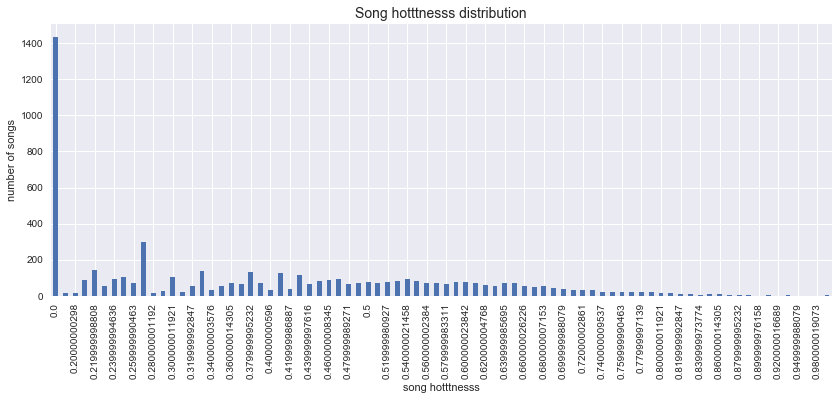

In [22]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = round(data['song hotttnesss'], 2).value_counts()\
                                                                   .sort_index()\
                                                                   .plot(kind='bar',
                                                                         grid=True,
                                                                         figsize=(14, 5));

ax.set_title('Song hotttnesss distribution', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_wtih_step(ax, 2)

In [23]:
data[data['song hotttnesss']==0].count()[0]

1434

From this plot, we see that a really large number of songs have a `song hotttnesss` of 0.
As a result, the bars corresponding to a non-zero `song hotttnesss` tend to be rather squeezed. 
Below, we provide the same barplot, but excluding the 0 values (1434 of them), to see better what happens.

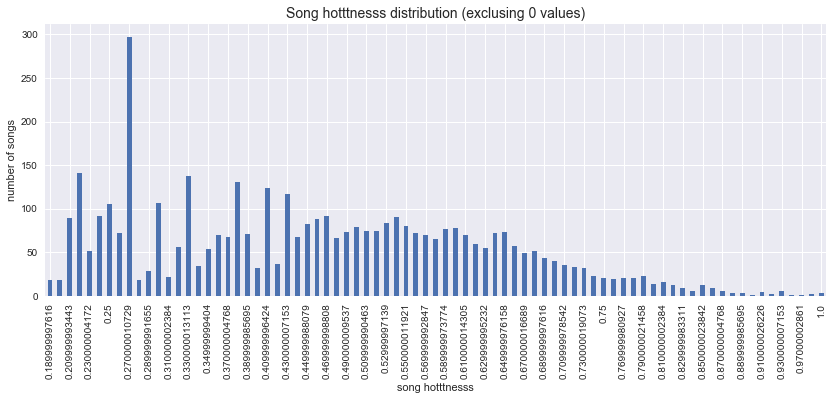

In [24]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = round(data[data['song hotttnesss'] > 0]['song hotttnesss'], 2).value_counts()\
                                                                   .sort_index()\
                                                                   .plot(kind='bar',
                                                                         grid=True,
                                                                         figsize=(14, 5));

ax.set_title('Song hotttnesss distribution (exclusing 0 values)', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('number of songs');
set_ticks_wtih_step(ax, 2)

The distribution of the `song hotttness` does not seem to correspond to a particular known distribution.
Most of the songs have an average to low `song hotttnesss`.
This will still be useful for determining what are the features that could make a song unpopular.

#### Release year

In [705]:
describe(data, 'year', True)

,year
count,10000.000000
mean,934.704600
std,996.650657
min,0.000000
25%,0.000000
50%,0.000000
75%,2000.000000
max,2010.000000


Like for the `song hotttnesss`, we see that the minimum `year` is 0. Here however, 0 actually stands for `undefined`. In our statistics, we will therefore not include those songs for which a certain feature is undefined, as this would bias the distributions.

In [706]:
describe(data, 'year', False)

,year
count,4680.000000
mean,1997.232051
std,11.686691
min,1926.000000
25%,1993.000000
50%,2001.000000
75%,2006.000000
max,2010.000000


Now the earliest `year` is 1926, which indeed appears to  be more realistic. The majority of the songs in the dataset has been released in the last 20 years, although the most recent ones date back to 2010 already. 

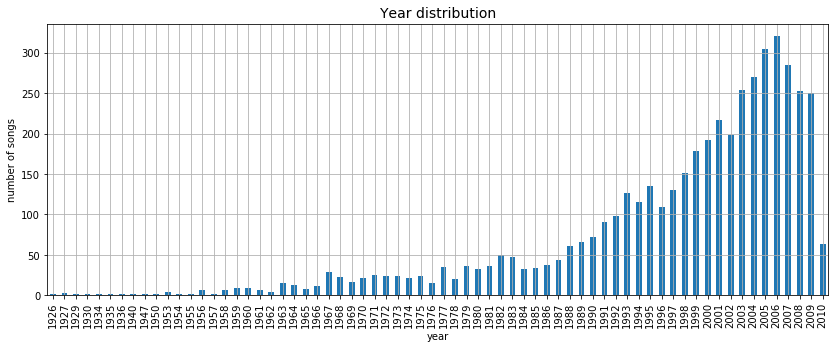

In [707]:
ax = data[data['year'] > 0]['year'].value_counts()\
                                   .sort_index()\
                                   .plot(kind='bar',
                                         grid=True,
                                         figsize=(14, 5));
        
ax.set_title('Year distribution', fontsize=14)
ax.set_xlabel('year')
ax.set_ylabel('number of songs');

Most of the songs we are going to deal with came out in 2000 and later. Hopefully, the ones which were popular in 2011, when the Million Song Dataset was created, remain so to these days. Otherwise, predicting the 2018's best hit might prove more challenging than expected!

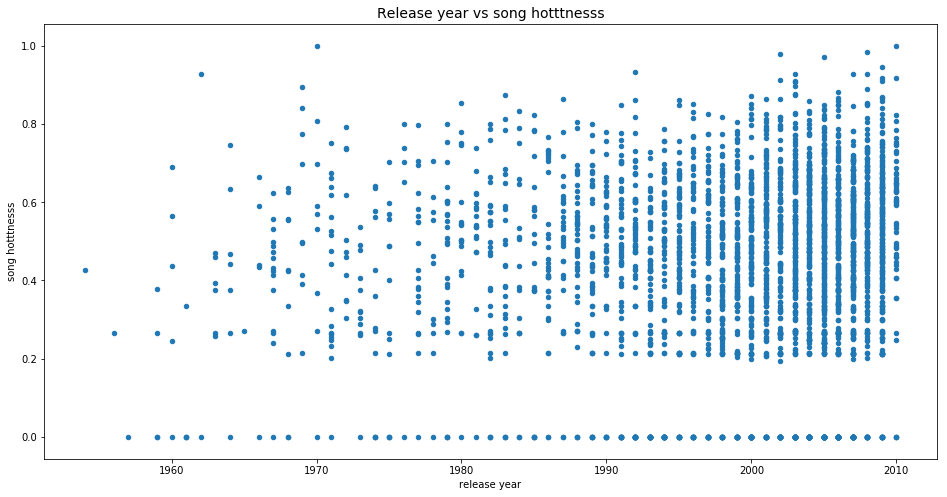

In [708]:
ax = data[(data['year'] != 0) ].plot(kind='scatter', x='year', y='song hotttnesss', figsize=(16,8))
ax.set_title('Release year vs song hotttnesss', fontsize=14)
ax.set_xlabel('release year')
ax.set_ylabel('song hotttnesss');

<div class="alert alert-warning">
Nb: Note the strange gap between 'song hotttness' = 0 and 0.2
<br>After a small investigation, we simply see that over the 26 songs in this range, only 3 have a year not equal to 0.
</div>

In [709]:
data[ (data['song hotttnesss'] > 0) & (data['song hotttnesss'] < 0.2) & (data['year'] != 0)]['song hotttnesss']

70      0.199238
278     0.193858
1009    0.199683
Name: song hotttnesss, dtype: float32

In [713]:
data_valid= data[(data['song hotttnesss'] != 0) & (data['year'] != 0)]
source = ColumnDataSource(data=dict(
    y=data_valid['song hotttnesss'],
    x=data_valid['year'],
    title=data_valid['title'],
    artist=data_valid['artist name'],
    song_hotttnesss=data_valid['song hotttnesss'],
    year=data_valid['year']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Artist', '@artist'),
    ('Song hotttnesss', '@song_hotttnesss'),
    ('Year', '@year')
])

hover_scatter_plot(source, hover, 
                   'Song hotttnesss vs release year', 'release year', 'song hotttnesss',
                    None, None, 'horizontal', 'MSD', 900, 600)

Most songs with the highest `song hotttnesss` are among the most recent ones. 
This may be because they are genuinely more popular, or also because the MSD or the MSD subset sampled more songs from these last years.
*Immigrant Song* from Led Zeppelin appears to be an early hit.

#### Artist hotttnesss

In [326]:
data_a_h = round(data[data['artist hotttnesss'] > 0]['artist hotttnesss'], 2).value_counts().sort_index()

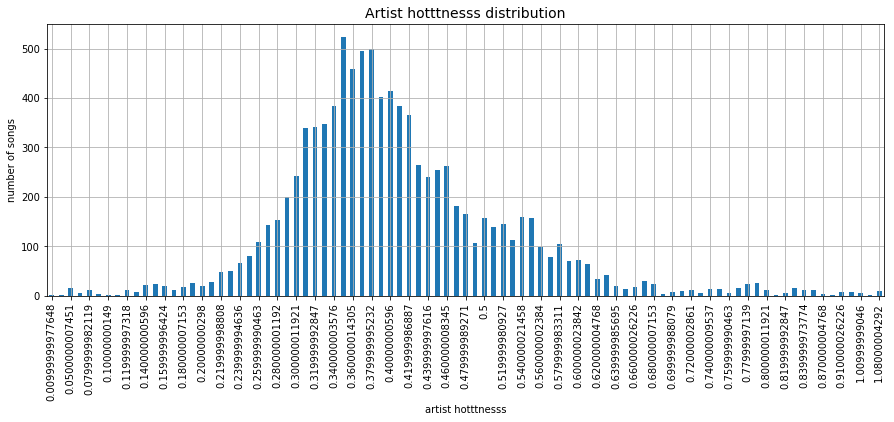

In [328]:
#round the 'song hotttnesss' to the nearest hundredth, in order to limit the number of bins
ax = data_a_h.plot(kind='bar',grid=True,figsize=(15, 5));
ax.set_title('Artist hotttnesss distribution', fontsize=14)
ax.set_xlabel('artist hotttnesss')
ax.set_ylabel('number of songs');

set_ticks_wtih_step(ax, 2)

The distribution of the `artist hotttnesss` appears to be Gaussian-like, except for the fact that it is not really symetric: there are two many values between 0.5 and 0.6 for it to be considered Gaussian.

According to The Echo Nest, these are the artists with the highest `artist hotttnesss` score

In [340]:
threshold = 0.9
data_tmp = data[data['artist hotttnesss'] > threshold].sort_values('artist hotttnesss', ascending=False)[['artist name', 'artist hotttnesss']].drop_duplicates().reset_index(drop=True)
data_tmp

,artist name,artist hotttnesss
0,Kanye West,1.082503
1,Kanye West / Adam Levine,1.082503
2,Kanye West / Consequence / CamRon,1.082503
3,Kanye West / Lupe Fiasco,1.082503
4,Daft Punk,1.021256
5,Black Eyed Peas,1.005942
6,Black Eyed Peas / Les Nubians / Mos Def,1.005942
7,Black Eyed Peas / Terry Dexter,1.005942
8,Taylor Swift,0.922412
9,Coldplay,0.916053


However, we see that many of these "artists" are actually collaborations, and that the `artist hotttnesss` does not change for the lead artist. 
For clarity, we only keep the entries about single artists.

In [341]:
# filter out collaborations
data_tmp = data_tmp[~data_tmp['artist name'].str.contains('/')]
data_tmp

,artist name,artist hotttnesss
0,Kanye West,1.082503
4,Daft Punk,1.021256
5,Black Eyed Peas,1.005942
8,Taylor Swift,0.922412
9,Coldplay,0.916053
10,Rihanna,0.908203


#### Artist hotttnesss vs song hotttnesss

We now want to verify whether an artist with a low/high `artist hotttnesss` value also has a low/high `song hotttnesss` average.
We expect this to be the case, although it would also be interesting to find see which unpopular artist released popular songs.

In [25]:
# group by 'artist name' and take the average of the 'song hotttnesss's
artist_song_hotttnesss_avg = data.groupby('artist name')['artist name', 'song hotttnesss'].mean()
artist_song_hotttnesss_avg.rename(columns = {'song hotttnesss':'song hotttnesss average'}, inplace=True)
artist_song_hotttnesss_avg.reset_index(inplace=True)
artist_song_hotttnesss_avg.head()

,artist name,song hotttnesss average
0,!!!,0.0
1,(hed) p.e.,NaN
2,089 Clique feat. Minnesota Snipe & Skinny Cueball,0.0
3,089 Clique feat. Prophet,0.0
4,1. Futurologischer Congress,0.0


In [26]:
print('Number of rows:', len(artist_song_hotttnesss_avg))

Number of rows: 4408


In [27]:
# keep the 'artist name' and the 'artist hotttnesss'
artist_hotttnesss = data[['artist name', 'artist hotttnesss']]
artist_hotttnesss = artist_hotttnesss.drop_duplicates()
artist_hotttnesss.reset_index(drop=True, inplace=True)
artist_hotttnesss.head()

,artist name,artist hotttnesss
0,Casual,0.401998
1,The Box Tops,0.417500
2,Sonora Santanera,0.343428
3,Adam Ant,0.454231
4,Go,0.401724


In [28]:
print('Number of rows:', len(artist_hotttnesss))

Number of rows: 4566


Oddly, we see that there are more rows in this dataframe than in the previous one, although the number of artist should be the same in both.
We will therefore take the average of the `artist hotttnesss` for artists with multiple `artist hotttnesss` values.

In [29]:
artist_hotttnesss = pd.DataFrame(artist_hotttnesss.groupby('artist name')['artist hotttnesss'].mean())
artist_hotttnesss.reset_index(inplace=True)
artist_hotttnesss.head()

,artist name,artist hotttnesss
0,!!!,0.482131
1,(hed) p.e.,0.324881
2,089 Clique feat. Minnesota Snipe & Skinny Cueball,0.000000
3,089 Clique feat. Prophet,0.000000
4,1. Futurologischer Congress,0.256978


In [30]:
print('Number of rows:', len(artist_hotttnesss))

Number of rows: 4408


The number of rows is now the same in both dataframes. 
The next step consists of merging the two dataframes on the `artist name`.

In [31]:
df = pd.merge(artist_hotttnesss , artist_song_hotttnesss_avg, on='artist name', how='outer')
df.head()

,artist name,artist hotttnesss,song hotttnesss average
0,!!!,0.482131,0.0
1,(hed) p.e.,0.324881,NaN
2,089 Clique feat. Minnesota Snipe & Skinny Cueball,0.000000,0.0
3,089 Clique feat. Prophet,0.000000,0.0
4,1. Futurologischer Congress,0.256978,0.0


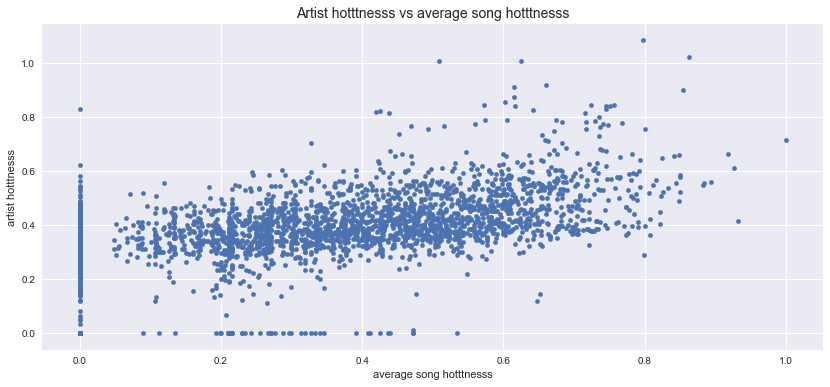

In [32]:
ax = df.plot(kind='scatter', x='song hotttnesss average', y='artist hotttnesss', figsize=(14, 6));
ax.set_title('Artist hotttnesss vs average song hotttnesss', fontsize=14)
ax.set_xlabel('average song hotttnesss')
ax.set_ylabel('artist hotttnesss');

In [35]:
source = ColumnDataSource(data=dict(
    y=df['song hotttnesss average'],
    x=df['artist hotttnesss'],
    artist=df['artist name']
))

hover = HoverTool(tooltips=[
    ('Artist', '@artist')
])

hover_scatter_plot(source, hover, 
                   'average song hotttnesss vs artist hotttnesss', 'average song hotttnesss', 'artist hotttnesss',
                    None, None, 'horizontal', 'MSD', 900, 600)

As expected, there is a visible correlation between the `artist hotttnesss` and the average `song hotttnesss` for a given artist, with the average `song hotttnesss` increasing when the `artist hotttnesss` increases, and vice-versa.

#### Song duration

In [350]:
describe(data, 'duration', False)

,duration
count,10000.000000
mean,238.507278
std,114.137314
min,1.044440
25%,176.032196
50%,223.059143
75%,276.375061
max,1819.767700


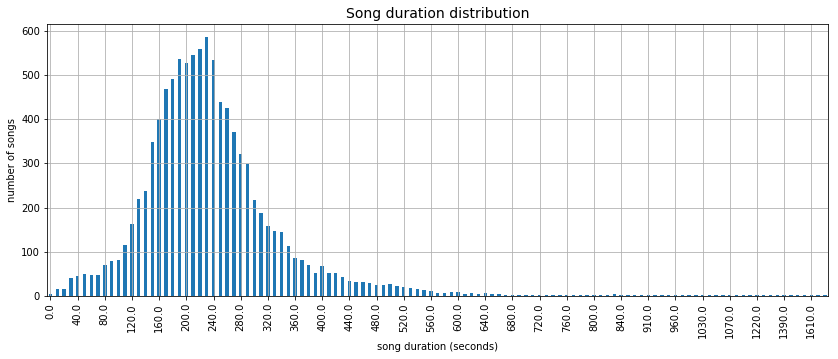

In [351]:
ax = round(data['duration'], -1).value_counts()\
                                .sort_index()\
                                .plot(kind='bar', 
                                      grid=True,
                                      figsize=(14, 5));
        
ax.set_title('Song duration distribution', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('number of songs')
set_ticks_wtih_step(ax, 4)

The `song duration` may be following a lognormal distribution.
The data is asymetric, with most outliers lying to the right, and some to the left: the most common distributions for this type of data are the lognormal, the Gamma, the Weibull distributions.
Since many natural phenomenons related to some *length* have been observed to follow a lognormal ditribution, then most likely so does the `song duration`.

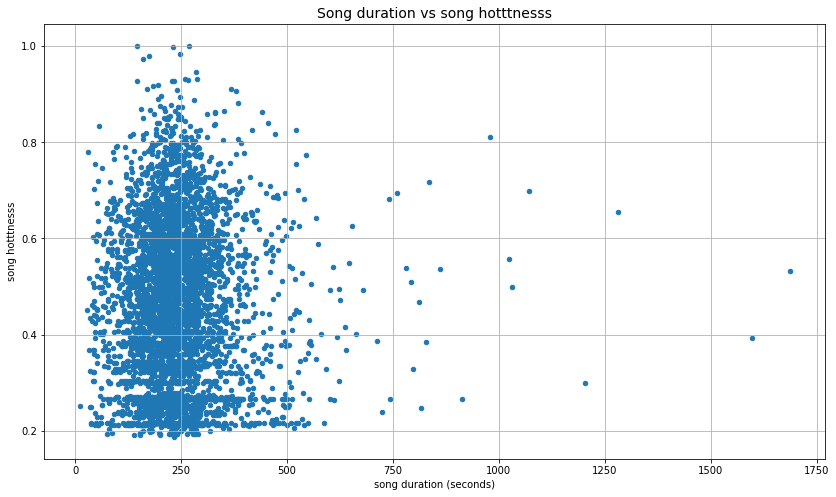

In [685]:
ax = data[data['song hotttnesss'] != 0].plot(kind='scatter', x='duration', y='song hotttnesss', figsize=(14,8), grid=True);
ax.set_title('Song duration vs song hotttnesss', fontsize=14)
ax.set_xlabel('song duration (seconds)')
ax.set_ylabel('song hotttnesss');

In [136]:
data_valid= data[data['song hotttnesss'] != 0]
source = ColumnDataSource(data=dict(
    y=data_valid['song hotttnesss'],
    x=data_valid['duration'],
    title=data_valid['title'],
    artist=data_valid['artist name'],
    song_hotttnesss=data_valid['song hotttnesss'],
    duration=data_valid['duration']
))

hover = HoverTool(tooltips=[
    ('Title', '@title'),
    ('Artist', '@artist'),
    ('Song hotttnesss', '@song_hotttnesss'),
    ('Duration', '@duration')
])

hover_scatter_plot(source, hover, 
                   'Song hotttnesss vs song duration', 'song duration (seconds)', 'song hotttnesss',
                    None, None, 'horizontal', 'MSD', 800, 400)

There does not seem to be any particular correlation between the `song hotttnesss` and the `song duration`.
We observe that the most popular songs are neither particularly long or particularly short, but have a `song duration` around the mean.

#### Artist terms

The `artist terms` feature for each song roughly corresponds to the music styles associated to this artist, according to The Echo Nest.
Additionally, there are the `artist terms weight` and the `artist terms freq`, which represent the weight respectively the frequency of each artist term (both between 0.0 and 1.0).

In [170]:
top_list = data['artist terms']
artist_terms_all = [item for sublist in top_list for item in sublist]
artist_terms_distinct = set(artist_terms_all)

print('Total number of artist terms:', len(artist_terms_all))
print('Number of distinct artist terms:', len(artist_terms_distinct))

Total number of artist terms: 266611
Number of distinct artist terms: 3502


In [70]:
serie = pd.Series(artist_terms_all).value_counts()

In [71]:
serie.sort_values(ascending=False).head(10)

rock                6493
pop                 5476
electronic          4453
jazz                3596
united states       3084
hip hop             2926
alternative rock    2753
folk                2598
alternative         2586
soul                2491
dtype: int64

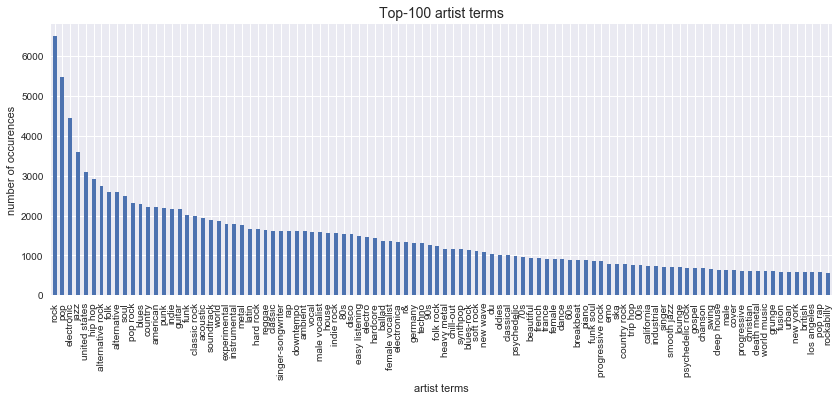

In [72]:
top = 100
ax = serie.sort_values(ascending=False).head(top)\
                                       .plot(kind='bar',
                                             grid=True,
                                             figsize=(14, 5));
    
ax.set_title('Top-' + str(top) + ' artist terms', fontsize=14)
ax.set_xlabel('artist terms')
ax.set_ylabel('number of occurences');

It would seem the songs in the MSD subset (and most likely the MSD dataset in general) are heavily rock and pop oriented.

In [344]:
threshold = 0.9
top_songs = data[data['song hotttnesss'] >= threshold]

In [345]:
top_artist_terms = flatmap(top_songs['artist terms'])
top_artist_terms_weight = flatmap(top_songs['artist terms weight'])

In [346]:
list_tuples = list(zip(top_artist_terms, top_artist_terms_weight))

In [347]:
from collections import defaultdict

groups = defaultdict(list)

#group by term
for item in list_tuples:
    groups[item[0]].append(item[1])

#compute the mean
for item in groups.items():
    groups[item[0]] = (np.mean(item[1]), np.std(item[1]))
                       

In [348]:
top_artist_terms_sorted = sorted(groups.items(), key=lambda value: value[1][0], reverse=True)

In [349]:
df = pd.DataFrame()
df['artist terms'] = [item[0] for item in top_artist_terms_sorted]
df['mean artist terms weight'] = [item[1][0] for item in top_artist_terms_sorted]
df['std artist terms weight'] = [item[1][1] for item in top_artist_terms_sorted]
df.head(20)

,artist terms,mean artist terms weight,std artist terms weight
0,teen pop,1.000000,0.000000
1,rap rock,1.000000,0.000000
2,experimental rock,1.000000,0.000000
3,dirty south rap,1.000000,0.000000
4,jazz rap,1.000000,0.000000
5,piano rock,0.999826,0.000000
6,post-grunge,0.999634,0.000000
7,pop punk,0.985320,0.014680
8,indie pop,0.983775,0.000000
9,soul jazz,0.973970,0.000000


<function matplotlib.pyplot.tight_layout>

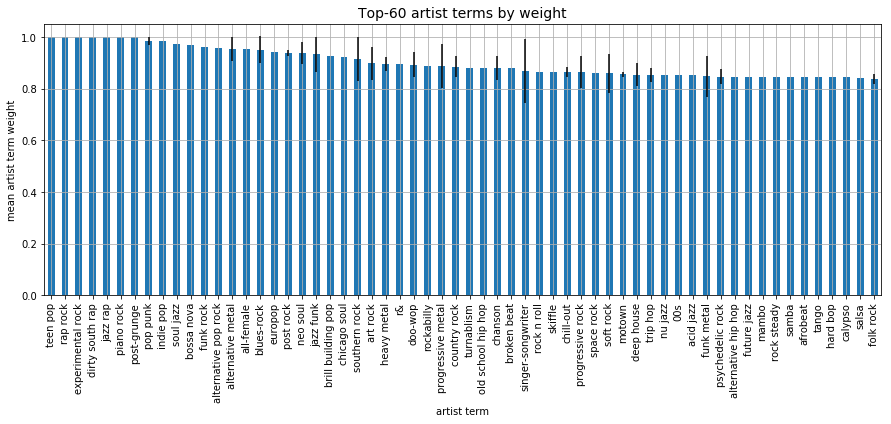

In [687]:
top = 60
error = df.head(top)['std artist terms weight']
ax = df.head(top)['mean artist terms weight'].plot(kind='bar', yerr=error, grid=True, figsize=(15, 5));

ax.set_title('Top-' + str(top) + ' artist terms by weight', fontsize=14)
ax.set_xlabel('artist term')
ax.set_ylabel('mean artist term weight')
ax.set_xticklabels(df['artist terms']);
plt.tight_layout

In [242]:
#consider regrouping artist terms into less groups
#"rap rock", "funk rock", funk rap", "jazz funk", "jazz rap", "jazz rock" ...........

For now, we did not analyse the `artist mbtags`, since compared to the `artist terms`, many songs were at that time not evaluated.

#### Beats

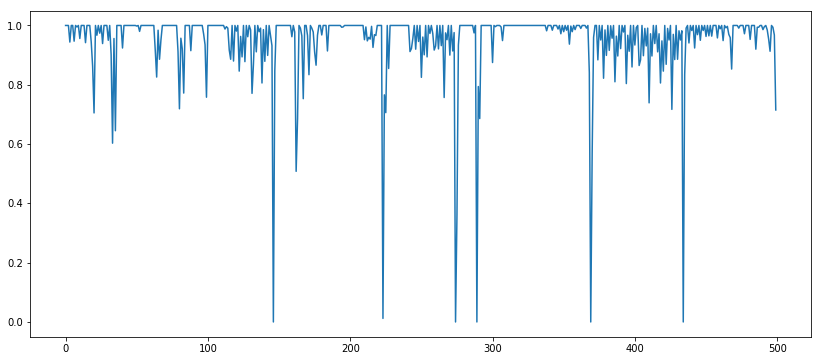

In [688]:
idx = 9
plt.figure(figsize=(14, 6))
serie = data['beats confidence'][idx]
plt.plot(np.arange(0,len(serie)), serie);

#### Geography
To be explored...


#### Key
There is 24 of them. Twelve are Majors and the all have what we call a minor relative. The major keys are in order :
$$ C - G - D - A - E - B - F\# - C\# - A\flat - E\flat - B\flat - F $$
as we can see in this picture :

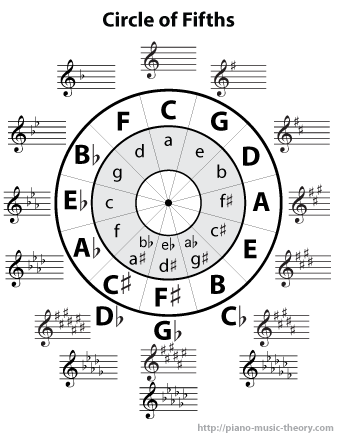

In [692]:
from IPython.display import Image
Image("img/fifths.png")

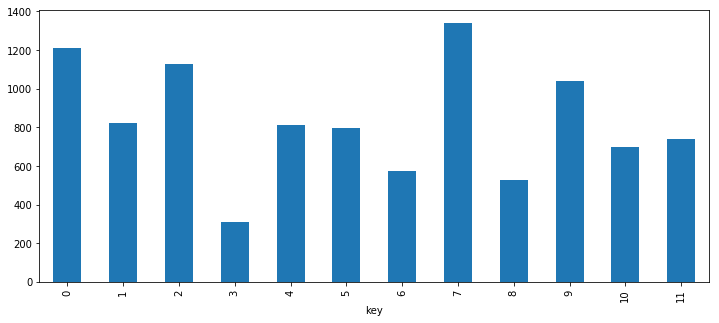

In [693]:
data_key = data.groupby('key')['key'].count()
data_key.index = data_key.index.astype(int)
data_key.sort_index().plot(kind='bar',figsize=(12,5))

We checked (manually...with the help of "findsongtempo.com") these song to get the matching between the key in data and the real key :

In [695]:
dd = pd.DataFrame()
for key in range(12) :
     dd = dd.append((data[(data['key'] == str(key)) 
      & (data['artist hotttnesss'] > 0.6)
      & (data['key confidence'] > 0.84)][['artist name', 'title','key confidence', 'key']]).head(1))
dd

,artist name,title,key confidence,key
660,Radiohead,Subterranean Homesick Alien,0.847,0
1059,Lloyd Banks,South Side Story,1.000,1
1427,Jack Johnson,You And Your Heart,1.000,2
247,U2,Kite Live from Sydney,0.878,3
507,Shakira,Pienso En Ti,0.970,4
2559,Eminem,Beautiful,1.000,5
9226,Bon Jovi / Ray Davies,Celluloid Heroes,0.896,6
108,Martina McBride,I Cant Stop Loving You,0.960,7
3336,Enrique Iglesias,Do You Know? (The Ping Pong Song),0.918,8
3097,Enrique Iglesias,Si Juras Regresar,0.930,9


Results by exploration :

| Key number | Key |
|:-----:|-----|-|
|0|C| |
|1|C$\sharp$|
|2|D| 
|3|E$\flat$| 
|4|E| 
|5|F| 
|6|?| 
|7|G| 
|8|A$\flat$| 
|9|A| 
|10|B$\flat$| 
|11| ?| 

We found 2 inccorect/unprecise results. But we can see that the key isn't the index in the fifths cycle, but simply the 12 half tone in the music scale.

In [697]:
key_to_explore = 5
(data[(data['key'] == str(key_to_explore)) 
      & (data['artist hotttnesss'] > 0.6)
      & (data['key confidence'] > 0.8)][['artist name', 'title','key confidence']]).head(1)

,artist name,title,key confidence
2559,Eminem,Beautiful,1.0


By further analysis, it is important that we can select the key of our song. 

#### Non-evaluated features

Unfortunately, some features such as `energy` or `danceability` happen to not have been evaluated for any of the songs in the Million Song Dataset subset, so that we were not able to use them in this first analysis.

The whole Million Song Dataset most likely contains a few songs were these features have been evaluated though.

In [240]:
describe(data, 'energy', True)

,energy
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


In [241]:
describe(data, 'danceability', True)

,danceability
count,10000.0
mean,0.0
std,0.0
min,0.0
25%,0.0
50%,0.0
75%,0.0
max,0.0


## Applying the analysis to the Million Song Dataset *(milestone 3)*

Once we move to the whole Million Song Dataset, we will obviously not be saving 280 GB to .csv files.

What we will do instead is collect the data from the cluster using the `GetData.py` Python script.
In this script, we will be dropping the features we are not interested in, which will reduce the size of the data per song significantly (e.g. `segments timbre`, `segment pitches`, ..., if we do not find a use for these feature in our analysis).

### Retrieving the data using a json

In [716]:
import json
strjson = open('data.json').read()
strjson = '{"columns":["year", "artist latitude", "artist longitude", "artist hotttnesss", "artist id", "song id", "title", "artist terms", "artist terms weight", "song hotttnesss", "danceability", "duration", "energy"],"data":['+strjson[:-2]+']}' 
json = json.loads(strjson)



In [717]:
data = pd.read_json(strjson,orient='split')

In [718]:
data.head()

,year,artist latitude,artist longitude,artist hotttnesss,artist id,song id,title,artist terms,artist terms weight,song hotttnesss,danceability,duration,energy
0,1996,40.73197,-74.17418,0.620222,AR30R5E1187B9AD78A,SODYOQM12A58A7A0E3,Somebody Bigger Than You And I,"[dance pop, quiet storm, r&b, ballad, soft roc...","[1.0, 0.9425660227595801, 0.8860338059041051, ...",0.400040,0,281.70404,0
1,2002,41.08419,-81.51406,0.741724,ARS8GNX1187B9B5141,SONYEUZ12AB01885E8,Brooklyn Bound,"[blues-rock, punk blues, blues, alternative ro...","[1.0, 1.0, 0.9131619499536121, 0.8480219466715...",0.742843,0,189.96200,0
2,2010,51.50632,-0.12714,0.458829,ARKFJI71187FB55484,SODHKYQ12AC4685299,October,"[folktronica, indie pop, indie, electronica, f...","[1.0, 0.830558137395466, 0.8066174871292141, 0...",0.758061,0,229.69424,0
3,2004,41.88415,-87.63241,0.500720,ARCVU3T1187FB4D79D,SONRQOA12AB0186E36,If U Ever,"[neo soul, soul jazz, downtempo, nu-soul, smoo...","[1.0, 0.9819961205739891, 0.9012790060726951, ...",0.494470,0,255.21587,0
4,2005,63.13626,18.81030,0.415241,AR20YYS1187B9B9BB2,SOMKUGB12A8C140816,Utnyttjad Och Konsumerad,"[twee pop, indie pop, pop, sweden, scandinavia...","[1.0, 0.915353755243233, 0.846228290787536, 0....",0.407975,0,147.12118,0


In [721]:
strjson[:1000]

'{"columns":["year", "artist latitude", "artist longitude", "artist hotttnesss", "artist id", "song id", "title", "artist terms", "artist terms weight", "song hotttnesss", "danceability", "duration", "energy"],"data":[[1996, 40.731969999999997, -74.174180000000007, 0.62022161333903358, "AR30R5E1187B9AD78A", "SODYOQM12A58A7A0E3", "Somebody Bigger Than You And I", ["dance pop", "quiet storm", "r&b", "ballad", "soft rock", "easy listening", "urban", "female vocalist", "soundtrack", "pop", "disco", "smooth jazz", "adult contemporary", "oldies", "emo", "soul music", "neo soul", "hip hop", "classic rock", "80s", "soul", "singer-songwriter", "blues", "rock", "funk", "new wave", "club", "jazz", "pop rock", "90s", "american", "female", "rap", "hard rock", "00s", "alternative", "techno", "alternative rock", "folk", "indie"], [1.0, 0.9425660227595807, 0.8860338059041051, 0.883440796120808, 0.872197625338997, 0.8531063110468546, 0.8246736474720542, 0.8177924181767203, 0.815890562856696, 0.81089106

### To be done ...

### Features or combination of features making a song popular

### Evolution over time of features making a song popular

#### Geolocation

*This code needs not to be run once all coordinates have been queried and the file has been built.*

In [887]:
path_geolocation = './data/geolocation/'

Save all valid coordinates to file

In [893]:
# filter out NaN coordinates and drop duplicates
valid_coordinates = data[['artist latitude', 'artist longitude']].dropna().drop_duplicates()

# save all coordinates in a file
valid_coordinates.to_csv('coordinates.txt', sep=',', encoding='utf-8', header=None, index=False)

# make a list of coordinates
valid_coordinates =  list(zip(valid_coordinates['artist latitude'], valid_coordinates['artist longitude']))

print('Number of valid coordinates (i.e. not NaN):', len(list(set(valid_coordinates))))

Number of valid coordinates (i.e. not NaN): 621


In [888]:
from itertools import islice

def get_next_coordinates(start, end):
    coordinates_list = []
    with open(path_geolocation+'coordinates.txt') as f:
        for line in islice(f, start, end):
            line = line.rstrip('\n')
            coordinates = (float(line.split(',')[0]), float(line.split(',')[1]))
            coordinates_list.append(coordinates)
    return coordinates_list

In [1478]:
def get_coordinates(filename, skiplines):
    coordinates_list = []
    i = 1
    with open(path_geolocation+filename) as f:
        for line in f:
            if i not in skiplines:
                line = line.rstrip('\n')
                coordinates = (float(line.split(',')[0]), float(line.split(',')[1]))
                coordinates_list.append(coordinates)
            i+=1
    return coordinates_list

Perform reverse geolocalisation on the coordinates and save to file

In [1479]:
from pygeocoder import Geocoder
from pygeolib import GeocoderError

def query_reverse_geolocation(coordinates, filename):
    done = False
    
    while(not done):
        try:
            results = Geocoder.reverse_geocode(coordinates[0], coordinates[1])
            print(results.coordinates, ' ', results.country, ' ', results.city)
            
            # precision problem between queried coordinates and returned coordinates (<results.coordinates>)
            # --> do not store <results.coordinates>, but the queries coordinates
            country = results.country
            city = results.city

            with open(path_geolocation+filename, 'ab') as myfile:
                value = str(coordinates[0]) + '\t' + str(coordinates[1]) + '\t' + str(country) + '\t' + str(city) + '\n'
                myfile.write(value.encode('utf-8'))

            done = True
        except GeocoderError:
            print('Error OVER_QUERY_LIMIT' + ' -- try again later')
            time.sleep(5) # delay in seconds

In [1480]:
#note: incorrect 411 and 569 coordinates, so skip these (line number in .csv file)
skiplines = [411, 569]
filename = 'coordinates.txt'
coordinates_list = get_coordinates(filename, skiplines)

i = 1
for coordinates in coordinates_list:
    print('Querying coordinates #', i, '...')
    filename_to = 'coordinates_map_tmp.txt' #write to this file
    query_reverse_geolocation(coordinates,filename_to)
    i += 1

Querying coordinates # 1 ...
(36.7186793, -4.4201636)   Spain   Málaga
Querying coordinates # 2 ...
(40.21787, -74.759721)   United States   Trenton
Querying coordinates # 3 ...
Error OVER_QUERY_LIMIT -- try again later
(51.4524066, -0.9960874)   United Kingdom   Reading
Querying coordinates # 4 ...
Error OVER_QUERY_LIMIT -- try again later
Error OVER_QUERY_LIMIT -- try again later
(23.6107248, -101.9414647)   Mexico   None
Querying coordinates # 5 ...
(34.1936322, -79.7690581)   United States   Florence
Querying coordinates # 6 ...
(53.97956019999999, -68.9146052)   Canada   None
Querying coordinates # 7 ...
Error OVER_QUERY_LIMIT -- try again later
(33.993621, -117.9709206)   United States   Hacienda Heights
Querying coordinates # 8 ...
(27.5309061, -99.50199909999999)   United States   Laredo


In [1178]:
df_coordinates = pd.read_csv(path_geolocation+'coordinates_map.txt', sep='\t', header=None)
df_coordinates.columns = ['latitude', 'longitude', 'country', 'city']
df_coordinates['latitude'] = df_coordinates['latitude'].astype(np.float32)
df_coordinates['longitude'] = df_coordinates['longitude'].astype(np.float32)
df_coordinates.head()

,latitude,longitude,country,city
0,35.149681,-90.048920,United States,Memphis
1,35.219620,-80.019547,United States,Mount Gilead
2,43.648560,-79.385330,Canada,Toronto
3,37.167931,-95.845016,United States,Independence
4,34.311089,-94.029778,United States,Umpire


In [1199]:
dict_coordinates = dict(zip([tuple(l) for l in df_coordinates[['latitude', 'longitude']].values.tolist()], 
                            [tuple(l) for l in df_coordinates[['country', 'city']].values.tolist()]))

In [1200]:
data_tmp = data[['artist latitude', 'artist longitude', 'song hotttnesss']].dropna()
data_tmp['country'] = data_tmp.apply(lambda x: dict_coordinates[(x['artist latitude'], x['artist longitude'])] if (x['artist latitude'], x['artist longitude']) in dict_coordinates else '', axis=1)
len(data_tmp[data_tmp['country'] != ''])

2206

In [1419]:
data_tmp = data[['artist latitude', 'artist longitude', 'song hotttnesss']].dropna()

data_tmp = pd.merge(data_tmp, df_coordinates, how='inner',
                    left_on=['artist latitude', 'artist longitude'],
                    right_on=['latitude', 'longitude'])

data_tmp = data_tmp.drop(['artist longitude', 'artist latitude'], axis=1)
print(len(data_tmp))
data_tmp.head()

2206


,song hotttnesss,latitude,longitude,country,city
0,0.000000,35.21962,-80.019547,United States,Mount Gilead
1,0.241524,35.21962,-80.019547,United States,Mount Gilead
2,0.339576,35.21962,-80.019547,United States,Mount Gilead
3,0.000000,35.21962,-80.019547,United States,Mount Gilead
4,0.928367,35.21962,-80.019547,United States,Mount Gilead


In [1426]:
data_tmp = data_tmp.groupby('country')['country', 'song hotttnesss'].mean().reset_index() #sort_values(ascending=False)
data_tmp.head()

,country,song hotttnesss
0,Argentina,0.399240
1,Australia,0.324115
2,Austria,0.000000
3,Barbados,0.614847
4,Belgium,0.253953


In [1420]:
country_codes = pd.read_csv(path_geolocation+'country_codes.csv', sep=',', encoding='latin-1')

# convert the ISO numeric code to string and pad it with 3 zeros (convention)
country_codes['iso numeric code'] = [str(s).zfill(3) for s in country_codes['iso numeric code']]

# convert all fields to string and remove potential blank spaces
country_codes['country'] = [str(s).strip() for s in country_codes['country']]
country_codes['iso alpha 2 code'] = [str(s).strip() for s in country_codes['iso alpha 2 code']]
country_codes['iso alpha 3 code'] = [str(s).strip() for s in country_codes['iso alpha 3 code']]
country_codes['iso numeric code'] = [str(s).strip() for s in country_codes['iso numeric code']]

country_codes.head()

,country,iso alpha 2 code,iso alpha 3 code,iso numeric code
0,Afghanistan,AF,AFG,004
1,Aland Islands,AX,ALA,248
2,Albania,AL,ALB,008
3,Algeria,DZ,DZA,012
4,American Samoa,AS,ASM,016


In [1428]:
data_tmp = pd.merge(data_tmp, country_codes, how='left',
                    left_on=['country'],
                    right_on=['country'])
data_tmp.head()

,country,song hotttnesss,iso alpha 2 code,iso alpha 3 code,iso numeric code
0,Argentina,0.399240,AR,ARG,032
1,Australia,0.324115,AU,AUS,036
2,Austria,0.000000,AT,AUT,040
3,Barbados,0.614847,BB,BRB,052
4,Belgium,0.253953,BE,BEL,056


In [1422]:
import json
state_geo_path = r'./data/geolocation/world_topo.json'

with open(state_geo_path) as json_data:
    world_topojson = json.load(json_data)

In [1435]:
lausanne_coord = [46.519962, 6.633597]
map_world = folium.Map(location=lausanne_coord, tiles='cartodbpositron', zoom_start=2)

scale = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]

map_world.choropleth(geo_data=world_topojson, 
                    data=data_tmp,
                    columns=['iso alpha 3 code', 'song hotttnesss'],
                    threshold_scale=scale,
                    key_on='id',
                    topojson='objects.countries1',
                    fill_color='YlOrBr', fill_opacity=0.6, line_opacity=0.2,
                    legend_name='Average song hotttnesss')

map_world

In [1304]:
#for coordinates in valid_coordinates[0:100]:
#    folium.Marker([coordinates[0], coordinates[1]], popup='').add_to(map_world)

### Influence of lyrics on the popularity of a song

Official webpage of the musiXmatch dataset:
https://labrosa.ee.columbia.edu/millionsong/musixmatch
 
* Train set:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_dataset_train.txt.zip

* Test set:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_dataset_test.txt.zip

* 779k matches:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/mxm_779k_matches.txt.zip

* Full list of stemmed words:
http://labrosa.ee.columbia.edu/millionsong/sites/default/files/AdditionalFiles/full_word_list.txt.zip
(498,134 unique words, total of 55,163,335 occurrences)

#### Loading the data

In [18]:
path_lyrics = './data/lyrics/'

In [20]:
# load the 'full_word_list.txt' file, containing all the words present in all the songs
# use <encoding='utf-8-sig'> because of some weird oriental characters
full_word_list = pd.read_csv(path_lyrics+'full_word_list.txt', skiprows=7, sep='<SEP>', header=None, engine='python', encoding='utf-8-sig')
full_word_list.columns = ['word', 'count']

print('Number of words:', len(full_word_list))
full_word_list.head()

Number of words: 498134


,word,count
0,i,2078808
1,the,1863782
2,you,1744257
3,to,1067578
4,and,1055748


We immediately see that the top words in the lyrics are in fact the english stopwords 'I', 'the', 'you', 'to', 'and', ..., which is not surprising.

If we look at the last rows of the full list of words though, we see that some of the lyrics actually contain japanese "words":

In [21]:
full_word_list.tail(3)

,word,count
498131,｢ただのマイリー」と,1
498132,｢どうしたんだ｣と聞いた,1
498133,｢何を考えてる｣って,1


In fact, the Million Song Dataset seems to contain songs with lyrics written in many more languages than just English: by scrolling through the `full_word_list.txt` file, one can stop words which definitely do not come from English!

Unfortunately, such songs are very sparse - the word count actually indicates 1 for each japanese "word" in the list. This makes it very dificult to use them in the lyrics analysis.
But in any case, they do not appear in the top-5000 words kept in the `mxm_dataset_train.txt` and the `mxm_dataset_test.txt` datasets, so we will not concern ourselves further with them.

We will now load the top-5000 most frequent words overall the lyrics.

In [22]:
# load the top-5000 words
top_words_list = []

# the top-5000 words can be found after the line starting with '%' in the 'mxm_dataset_train.txt' file
with open(path_lyrics+'mxm_dataset_train.txt') as f:
    for line in f:
        if line.startswith('%'):
            top_words_list = line[1:] # drop the '%' marking the beginning of the line
            break

top_words_list = top_words_list.split(',')
print('Number of words:', len(top_words_list))
top_words_list[0:10]

Number of words: 5000


['i', 'the', 'you', 'to', 'and', 'a', 'me', 'it', 'not', 'in']

As observed just previously, many of the top-5000 words seem the be stopwords. 
This can't be helped though, since stopwords are indeed the most frequent words in practice.

By definition, stopwords are words that bear little meaning, in particular for search queries, and which are therefore often removed during the preprocessing step.
However, there are two reasons we will not remove the stopwords from our lyrics analysis:
* The first one is that we are not dealing with search queries.
* The second one is because songs are intrinsically based on repetitive patterns, even more than prose, so that some of these stopwords can actually be considered as an important part of the lyrics.

We now load the musiXmatch matches from the both the `mxm_dataset_train.txt` dataset and the `mxm_dataset_test.txt` dataset.
Since we are not going to do any prediction task, we simply use both datasets as one single dataset.

In [23]:
def load_mxm_dataset(filename):
    
    entries = []
    with open(path_lyrics+filename) as f:
        # skip the first 18 lines
        lines = f.readlines()[18:] 
        for line in lines:
            line = line.split(',')

            entry = []
            entry.append(line[0])
            entry.append(line[1])

            words = {}
            line = line[2:]
            for item in line:            
                words[int(item.split(':')[0])] = int(item.split(':')[1])
            entry.append(words)

            entries.append(entry)
    
    return entries

In [33]:
# load the 'mxm_dataset_train.txt' file
filename = 'mxm_dataset_train.txt'
entries = load_mxm_dataset(filename)

# load the 'mxm_data_set_test.txt' file
filename = 'mxm_dataset_test.txt'
entries.extend(load_mxm_dataset(filename))

print('Number of songs:', len(entries))

Number of songs: 237662


The musiXmatch dataset provides a matching between 779056 songs of the Million Song Dataset, but in total, there are only 237 662 (train set: 210 519, test set: 27 143) songs whose lyrics are provided (as a bag-of-word).
This means that at most this number of songs can be used for the lyrics analysis.

In [41]:
mxm_dataset = pd.DataFrame(entries)
mxm_dataset.columns = ['track id', 'mxm track id', 'words']
mxm_dataset.head()

,track id,mxm track id,words
0,TRAAAAV128F421A322,4623710,"{1: 6, 2: 4, 3: 2, 4: 2, 5: 5, 6: 3, 7: 1, 8: ..."
1,TRAAABD128F429CF47,6477168,"{1: 10, 3: 17, 4: 8, 5: 2, 6: 2, 7: 1, 8: 3, 9..."
2,TRAAAED128E0783FAB,2516445,"{1: 28, 2: 15, 3: 2, 4: 12, 5: 22, 6: 2, 7: 2,..."
3,TRAAAEF128F4273421,3759847,"{1: 5, 2: 4, 3: 3, 4: 2, 5: 1, 6: 11, 9: 4, 12..."
4,TRAAAEW128F42930C0,3783760,"{1: 4, 4: 5, 5: 7, 6: 2, 7: 4, 9: 1, 10: 1, 11..."


In [50]:
# load the 'mxm_779k_matches.txt' file
mxm_779k_matches = pd.read_csv(path_lyrics+'mxm_779k_matches.txt', skiprows=18, sep='<SEP>', header=None, engine='python')
mxm_779k_matches.columns = ['track id', 'artist name', 'title', 'mxm track id', 'mxm artist name', 'mxm title']

print('Number of songs matched:', len(mxm_779k_matches))
mxm_779k_matches.head()

Number of songs matched: 779056


,track id,artist name,title,mxm track id,mxm artist name,mxm title
0,TRMMMKD128F425225D,Karkkiautomaatti,Tanssi vaan,4418550,Karkkiautomaatti,Tanssi vaan
1,TRMMMRX128F93187D9,Hudson Mohawke,No One Could Ever,8898149,Hudson Mohawke,No One Could Ever
2,TRMMMCH128F425532C,Yerba Brava,Si Vos QuerÃ©s,9239868,Yerba Brava,Si vos queres
3,TRMMMXN128F42936A5,David Montgomery,"Symphony No. 1 G minor ""Sinfonie Serieuse""/All...",5346741,Franz Berwald,"Symphony No. 1 in G minor ""Sinfonie SÃ©rieuse""..."
4,TRMMMBB12903CB7D21,Kris Kross,2 Da Beat Ch'yall,2511405,Kris Kross,2 Da Beat Ch'yall


We now merge the 779k matched songs with their correspondong `song hotttnesss` and `words` bag of words.

In [51]:
mxm_779k_matches = mxm_779k_matches.merge(data[['track id', 'song hotttnesss']])
print('Number of songs matched in MSD:', len(mxm_779k_matches))

mxm_779k_matches = mxm_779k_matches.merge(mxm_dataset[['track id', 'words']])
print('Number of songs matched in musiXmatc:', len(mxm_779k_matches))

#mxm_779k_matches = mxm_779k_matches[['track id', 'artist name', 'title', 'words']]
mxm_779k_matches = mxm_779k_matches.drop(['mxm track id', 'mxm artist name', 'mxm title'], axis=1)
mxm_779k_matches.head(1)

Number of songs matched in MSD: 7506
Number of songs matched in musiXmatc: 2350


,track id,artist name,title,song hotttnesss,words
0,TRBGMWQ12903CC23CD,Eighteen Visions,Life's Blood,NaN,"{1: 3, 2: 5, 3: 2, 4: 1, 5: 3, 8: 1, 10: 3, 11..."


We see that there are indeed ??? songs matched between the musiXmatch ID dataset and the Million Song Dataset, and in the end, ??? songs matched between the Million Song Dataset and the musiXmatch bag-of-words lyrics dataset.

#### Analysis

We want to find out if there are certain words popular songs (i.e. with a high `song hotttnesss` value) tend to contain more frequently than songs with an average rating. 

In [96]:
def create_top_words_ranking(threshold, sort_by, verbose=False):
    top_mxm_779k_matches = mxm_779k_matches[mxm_779k_matches['song hotttnesss'] > threshold]

    # get all the words in the top songs, according to the threshold 
    words_dict_list = top_mxm_779k_matches['words'].tolist()

    # count the number of distinct words over these songs
    nb_words = len(list((flatmap([d.keys() for d in words_dict_list]))))
    
    if(verbose):
        print('Song hotttnesss threshold:', threshold)
        print('Number of songs selected:', len(top_mxm_779k_matches))
        print('Number of distinct words:', nb_words)

    top_words = pd.DataFrame()
    top_words['word id'] = (list((flatmap([d.keys() for d in words_dict_list]))))

    # map each word id to the acual corresponding word
    top_words['word'] = top_words.apply(lambda row: top_words_list[row[0]-1], axis=1)
    top_words.rename(columns={0:'word id'}, inplace=True)

    # count the number of song containing this word
    top_words = top_words.groupby(['word id', 'word']).size().reset_index()
    top_words.rename(columns={0:'song count'}, inplace=True)

    # count the total numbre of occurences by word
    top_words['total count'] = top_words['word id'].apply(lambda key: sum([d[key] for d in words_dict_list if key in d]))

    # compute the frequency of each word
    top_words['frequency'] = top_words['total count'].apply(lambda count: count/(1.0*nb_words))

    # sort the words according to their frequency, in descending order
    top_words = top_words.sort_values(sort_by, ascending=False).reset_index(drop=True)

    rank = []
    previous_rank = 1
    previous = top_words[sort_by][0]
    for item in top_words[sort_by]:
        if(item == previous):
            rank.append(previous_rank)
        else:
            rank.append(previous_rank + 1)
            previous_rank += 1
            previous = item

    top_words['rank'] = rank
    
    return top_words

In [97]:
threshold = 0.8
create_top_words_ranking(threshold, 'song count', True).head(10)

Song hotttnesss threshold: 0.8
Number of songs selected: 54
Number of distinct words: 4387


,word id,word,song count,total count,frequency,rank
0,2,the,47,523,0.119216,1
1,3,you,43,524,0.119444,2
2,4,to,43,288,0.065649,2
3,12,is,42,208,0.047413,3
4,8,it,40,285,0.064965,4
5,1,i,40,551,0.125598,4
6,5,and,40,266,0.060634,4
7,6,a,39,264,0.060178,5
8,9,not,37,192,0.043766,6
9,7,me,34,190,0.043310,7


If we sort the words by the number of songs which contain at least one occurence of this word, then we see that the word 'the' is ranked first, just like in the english word frequency.

Here however, we only counted the number of songs containing a certain word, and did not take into account the actual number of occurences of this word.
Moreover, stopwords are very likely to be consistently present in almost every songs. 
With an increasing `song hotttnesss` threshold, the number of selected songs decreases, and so does the number of distinct words. 
Hence, chances that the very common stopwords 'the', 'you', 'I', ... are placed in the top positions may be in the end only due to the fact that the lexical field decreases in size.
Ranking the words by song count provides some information, but may then not be the best approach.

We therefore try to rank the words by frequency over all selected songs, that is, by taking the total number of occurences of the word and dividing it by the total number of words.
The idea is that the frequency of some stopwords such as 'the', 'to', ... will not vary much with the `song hotttnesss`, while other may actually do so.

In [98]:
threshold = 0.8
create_top_words_ranking(threshold, 'frequency', True).head(20)

Song hotttnesss threshold: 0.8
Number of songs selected: 54
Number of distinct words: 4387


,word id,word,song count,total count,frequency,rank
0,1,i,40,551,0.125598,1
1,3,you,43,524,0.119444,2
2,2,the,47,523,0.119216,3
3,4,to,43,288,0.065649,4
4,8,it,40,285,0.064965,5
5,5,and,40,266,0.060634,6
6,6,a,39,264,0.060178,7
7,12,is,42,208,0.047413,8
8,9,not,37,192,0.043766,9
9,7,me,34,190,0.043310,10


Unsurprisingly, just like before, the same stopwords 'I', 'you', 'the', 'to', ... are ranked at the top positions. 
But with this approach, the word 'the' is not ranked first anymore.

What is interesting as well is that the word 'you', which is ranked 14th in the english word frequency, has a much higher frequency in the popular songs.
Inversely, the word 'the', which is ranked first in the english word frequency, is ranked "only" XXX.

We also see that 'you' is placed before 'I', whereas 'I' is ranked 11th for the word frequency in English.
Therefore, in order to make a song popular, it seems to be preferable for it to talk more about 'you' than 'I'!

---
The English word frequency of a word can be found at https://www.wordandphrase.info/frequencyList.asp (as a list) or also at https://www.wordfrequency.info/free.asp?s=y (by querying the word).

*(to complete when more data)*

In [88]:
def get_word_rank(word, ranking):
    if(len(ranking[ranking['word'] == word]['frequency'].values) == 0):
        return float('NaN')
    else:
        return ranking[ranking['word'] == word]['frequency'].values[0]

In [89]:
# define the threshold for the 'song hotttnesss'
thresholds = np.arange(0.0, 1.0, 0.02)

In [99]:
words_list = ['you', 'i', 'we', 'the', 'and', 'is', 'to', 'my', 'your']
word_ranks_dict = {}

for word in words_list:
    word_ranks_dict[word] = []

for threshold in thresholds:
    top_words_ranking = create_top_words_ranking(threshold, 'frequency', False)
    
    for word in words_list:
        rank = get_word_rank(word, top_words_ranking)
        word_ranks_dict[word].append(rank)

In [324]:
# to add a single word in words_ranks_dict
word = 'we'
word_ranks_dict[word] = []

for threshold in thresholds:
    top_words_ranking = create_top_words_ranking(threshold, False)
    rank = get_word_rank(word, top_words_ranking)
    word_ranks_dict[word].append(rank)

Song hotttnesss threshold: 0.0
Number of songs selected: 54
Song hotttnesss threshold: 0.2
Number of songs selected: 54
Song hotttnesss threshold: 0.4
Number of songs selected: 54
Song hotttnesss threshold: 0.8
Number of songs selected: 54


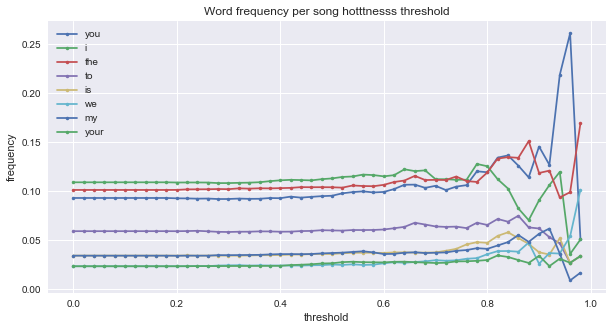

In [102]:
figure()
plt.figure(figsize=(10,5))

words_list = ['you', 'i', 'the', 'to', 'is', 'we', 'my', 'your']
for word in words_list:
    plt.plot(thresholds, word_ranks_dict[word], linestyle='-', marker='.')
#plt.gca().invert_yaxis()
plt.title('Word frequency per song hotttnesss threshold')
plt.xlabel('threshold')
plt.ylabel('frequency')
plt.legend(labels=words_list)

plt.show()

*(Yeah well, some trend, but not super conclusive... we need more data...!)*

Unfortunately, when the `song hotttnesss` threshold increases, less and less songs are selected.
Only XXX songs have a `song hotttnesss` greater or equal than 0.9, and there is only a single song with the highest `song hotttnesss`.
Therefore, it is difficult to formulate an interpretation out of the frequencies for the last couple of threshold values.

To make sure the frequency of words such as X, X or X indeed increases with the `song hotttnesss`, and not that popular songs just have fewer words, we also analyse these frequencies individually for each songs.

In [111]:
mxm_779k_matches.head()

,track id,artist name,title,song hotttnesss,words
0,TRBGMWQ12903CC23CD,Eighteen Visions,Life's Blood,NaN,"{1: 3, 2: 5, 3: 2, 4: 1, 5: 3, 8: 1, 10: 3, 11..."
1,TRBGMJF128F425E8EA,30 Seconds To Mars,End Of The Beginning,0.788862,"{1: 8, 2: 18, 3: 16, 4: 3, 5: 2, 6: 10, 8: 11,..."
2,TRBGMUA128F92E9A1C,RUN-DMC,Slow And Low,NaN,"{1: 9, 2: 21, 3: 8, 4: 4, 5: 13, 6: 10, 8: 15,..."
3,TRBGMAZ12903CC3707,Pierre Perret,L'idole des femmes,NaN,"{6: 1, 42: 9, 47: 5, 90: 2, 102: 8, 117: 2, 17..."
4,TRBGWQG128F92FB42D,Michael Stanley Band,Take The Time,0.000000,"{2: 21, 3: 13, 4: 4, 5: 9, 6: 3, 8: 7, 9: 3, 1..."


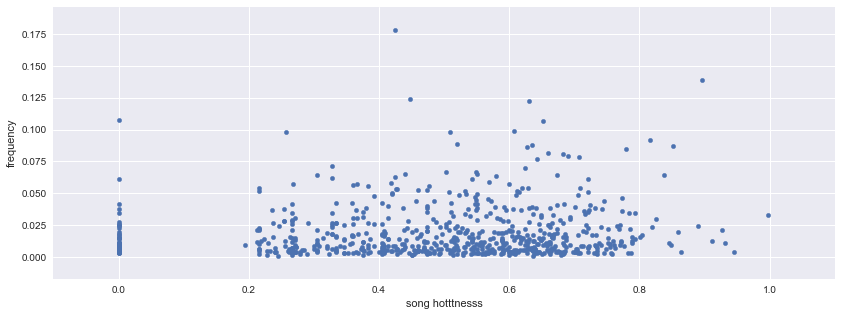

In [375]:
word = 'we'
word_id = top_words_list.index(word) + 1 # word indices start at 1 in the musiXmatch dataset

tmp = mxm_779k_matches.copy()
tmp['count'] = mxm_779k_matches['words'].apply(lambda word_dict: word_dict[word_id] if word_id in word_dict else 0)
tmp = tmp[tmp['count'] != 0]
tmp['length'] = mxm_779k_matches['words'].apply(lambda word_dict: sum([word_dict[key] for key in word_dict]))
tmp['frequency'] = tmp['count'] / tmp['length'] 

tmp.head()
ax = tmp.plot(kind='scatter', x='song hotttnesss', y='frequency', figsize=(14,5))
ax.set_xlim((-0.1, 1.1));

In [368]:
full_word_list.head()

,word,count
0,i,2078808
1,the,1863782
2,you,1744257
3,to,1067578
4,and,1055748


#### Lyrics length (estimated)

We estimate the length the lyrics for a song by summing all the occurences. 
Since only the occurences of the top-5000 words are available, this will only be an estimation of the actual lyrics length though.

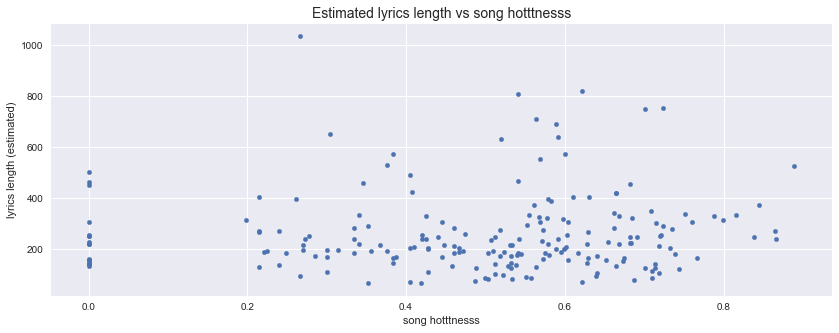

In [374]:
ax = tmp.plot(kind='scatter', x='song hotttnesss', y='length', figsize=(14,5))
ax.set_title('Estimated lyrics length vs song hotttnesss', fontsize=14)
ax.set_xlabel('song hotttnesss')
ax.set_ylabel('lyrics length (estimated)');

#### A look at the not-so-popular songs

In this section, we want to find out whether there are words that are only present in popular songs or in not-so-popular songs.

To do this, we collect two sets of words (always among the top-5000 most frequent ones): the ones for the songs with a `song hotttnesss` above a certain threshold (popular songs) and the ones for songs with a `song hotttnesss` under a certain threshold (not-so-popular songs).

We then take the difference between the set of words of popular songs and the set of words of not-so-popular songs for finding words present only in popular songs, and vice-versa for finding words present only in not-so-popular songs.

In [383]:
#intersection popular songs / crappy songs
tmp = mxm_779k_matches.copy()
head_threshold = 0.8
tail_threshold = 0.1
head = tmp[tmp['song hotttnesss'] > head_threshold]
tail = tmp[tmp['song hotttnesss'] < tail_threshold]

tail_words = set(flatmap([d.keys() for d in tail['words']]))
head_words = set(flatmap([d.keys() for d in head['words']]))

print('Number of words in common:', len(head_words.intersection(tail_words)))
print('Number of words only in songs with a song hotttnesss > ', head_threshold, ':', len(head_words.difference(tail_words)))
print('Number of words only in songs with a song hotttnesss < ', tail_threshold, ':', len(tail_words.difference(head_words)))

Number of words in common: 985
Number of words only in songs with a song hotttnesss >  0.8 : 333
Number of words only in songs with a song hotttnesss <  0.1 : 1504


In [365]:
list(map(lambda x: top_words_list[x-1], head_words.difference(tail_words)))
list(map(lambda x: top_words_list[x-1], tail_words.difference(head_words)))

['la',
 'y',
 'el',
 'mi',
 'e',
 'le',
 'si',
 'je',
 'por',
 'lo',
 'und',
 'da',
 'amor',
 'et',
 'con',
 'na',
 'sin',
 'una',
 'les',
 'al',
 'che',
 'cold',
 'lord',
 'il',
 'di',
 'non',
 'ti',
 'como',
 'para',
 'los',
 'may',
 'deep',
 'ma',
 'der',
 'set',
 'goe',
 'qui',
 'nicht',
 'eu',
 'las',
 'todo',
 'del',
 'late',
 'das',
 'des',
 'road',
 'reason',
 'dan',
 'quiero',
 'mai',
 'rise',
 'ha',
 'solo',
 'though',
 'vida',
 'ist',
 'blind',
 'young',
 'soon',
 'Ã\xa0',
 'red',
 'ein',
 's',
 'im',
 'ja',
 'somebodi',
 'mas',
 'esta',
 'noch',
 'su',
 'ni',
 'promis',
 'um',
 'power',
 'gave',
 'hay',
 'ser',
 'Ã©',
 'cuando',
 'pay',
 'den',
 'tout',
 'anymor',
 'jesus',
 'differ',
 'becom',
 'va',
 'nos',
 'zu',
 'mÃ¡s',
 'ladi',
 'pero',
 'afraid',
 'great',
 'wir',
 'nada',
 'mir',
 'children',
 'honey',
 'human',
 'bien',
 'dich',
 'porqu',
 'sorri',
 'secret',
 'per',
 'push',
 'm',
 'somewher',
 'vez',
 'low',
 'knee',
 'sie',
 'worri',
 'bout',
 'goin',
 'mon',
 '

In [ ]:
# - much more words in crappy songs not in popular songs than the reverse
# - some "crappy" songs are actually not written in English (Spanish, ...)
# - still not clear whether song hotttnesss of 0.0 means crappy
# - could still indicate a huge biais when song hotttnesss was rated (i.e. users rated mostly English songs)
#   in fact, all "popular songs" are in English
